In [2]:
import librosa
audio_data = '/content/drive/MyDrive/Project_Dataset/Data/EDA_WavFile/new/ChillingMusic.wav'
x , sr = librosa.load(audio_data)
print(type(x), type(sr))#<class 'numpy.ndarray'> <class 'int'>
print(x.shape, sr)#(94316,) 22050

<class 'numpy.ndarray'> <class 'int'>
(604359,) 22050


In [3]:
librosa.load(audio_data, sr=44100)

(array([0.11779785, 0.28727722, 0.23820496, ..., 0.13270569, 0.140625  ,
        0.14605713], dtype=float32), 44100)

In [4]:
import IPython.display as ipd
ipd.Audio(audio_data)

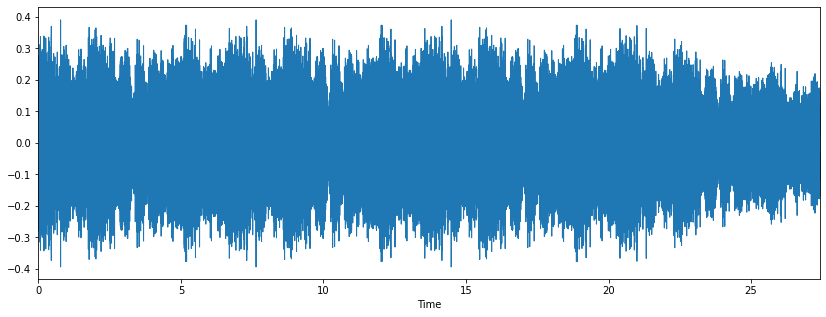

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

**Spectrogram**

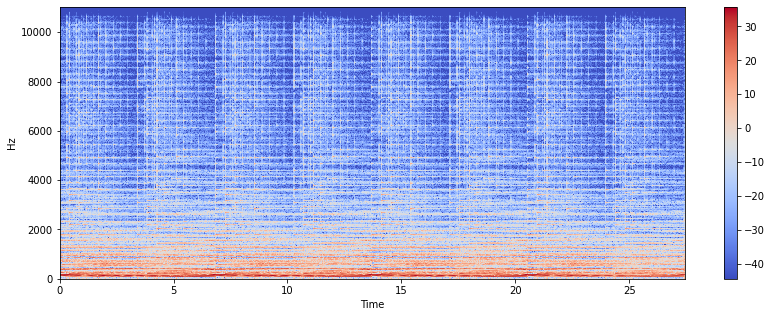

In [6]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

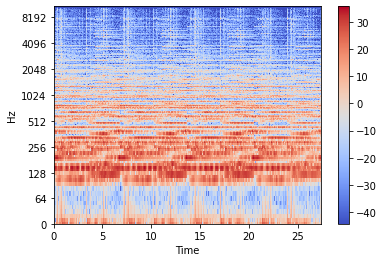

In [ ]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

**Feature** **extraction** **from** **Audio** **signal**

**1**. **Spectral** **Centroid**

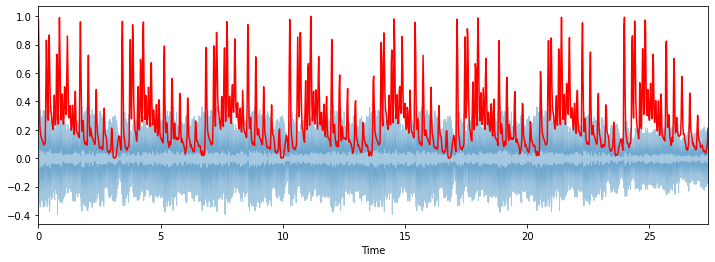

In [8]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
#(775,)
# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

**2**. **Spectral** **Rolloff**

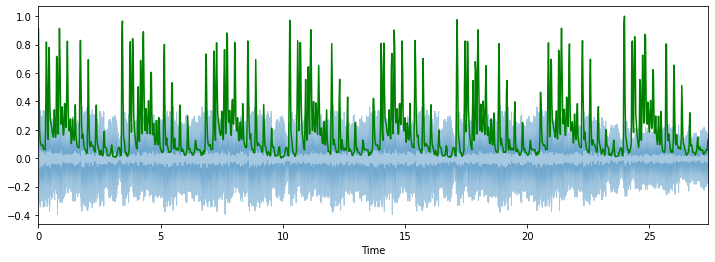

In [9]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='g')


**3**. **Spectral** **Bandwidth**

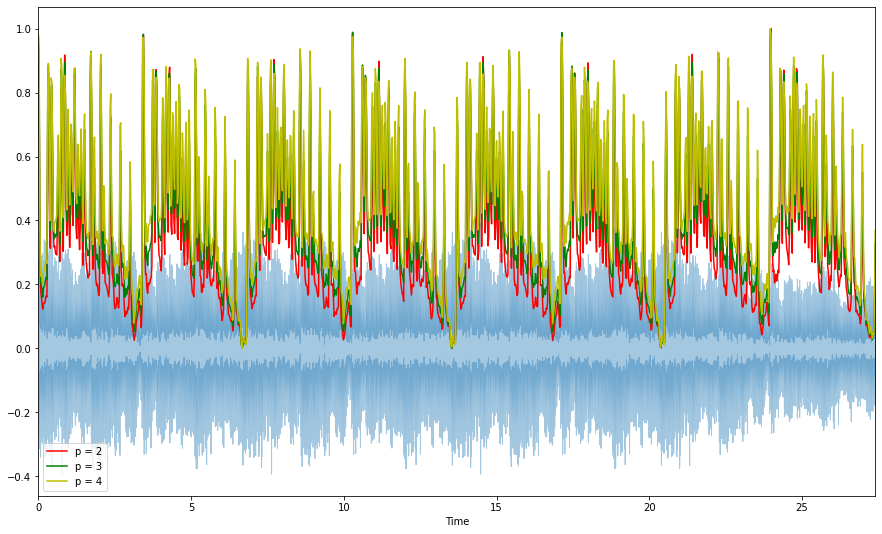

In [10]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

**4**. **Zero** - **Crossing** **Rate**

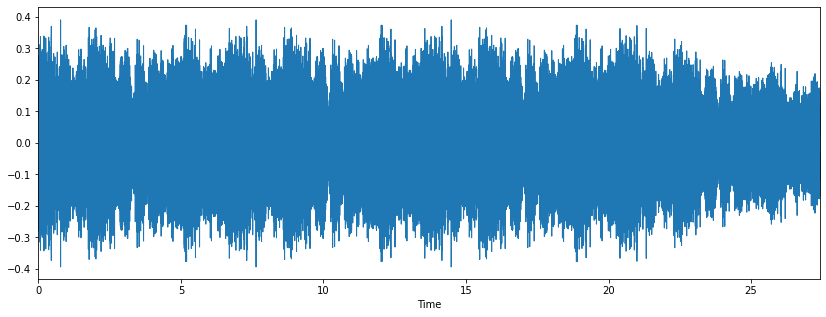

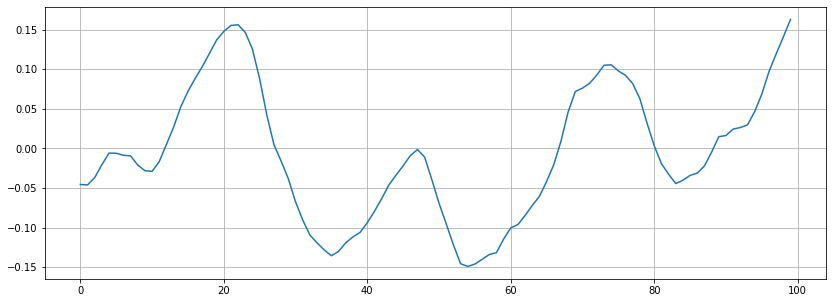

In [11]:
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [12]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

5


**5** . **Mel** - **Frequency** **Cepstral** **Coefficients**(**MFCCs**)

(20, 1181)


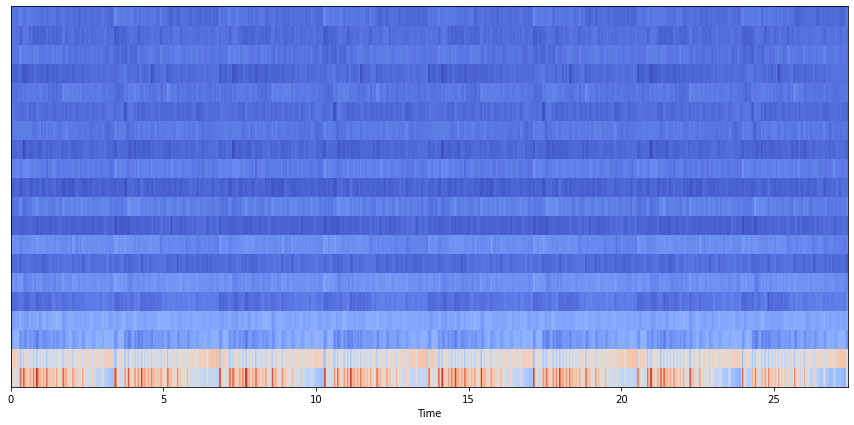

In [13]:
fs=2
mfccs = librosa.feature.mfcc(x, sr=fs)
print(mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

**6** . **Chroma** **feature**

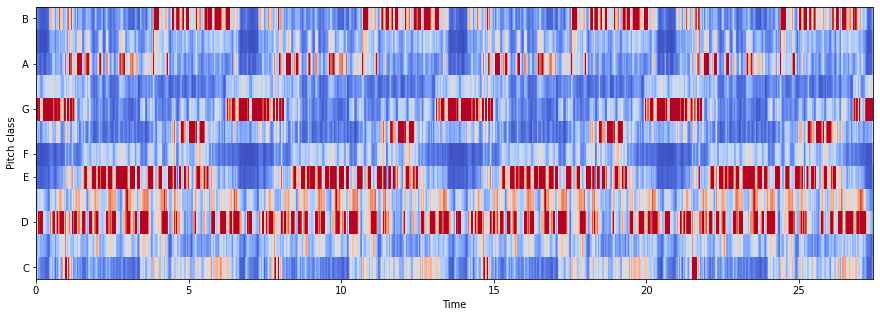

In [14]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

**Music** **Genre** **Classification**

**Import** **all** **the** **required** **libraries**

In [15]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')


**Spectrogram** **for** **every** **audio** **file**

In [16]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
genres_original = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres_original:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'./drive/MyDrive/Project_Dataset/Data/genres_original/{g}'):
        songname = f'./drive/MyDrive/Project_Dataset/Data/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

<Figure size 576x576 with 0 Axes>

In [17]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [18]:
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./drive/MyDrive/Project_Dataset/Data/genres_original/{g}'):
        songname = f'./drive/MyDrive/Project_Dataset/Data/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        rmse = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

**Loading** **Data**

In [20]:
data = pd.read_csv('dataset.csv')
data.head()# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)
data.head(5)

chroma_stft      rmse  spectral_centroid  ...    mfcc19     mfcc20  label
0     0.308590  0.091563        1835.494603  ... -4.409332 -11.703781  blues
1     0.291308  0.141796        1459.078483  ... -3.449033  -6.495510  blues
2     0.307921  0.131785        1451.754147  ... -4.693748  -8.638613  blues
3     0.404779  0.141191        1070.119953  ... -0.619690  -3.408233  blues
4     0.302346  0.103468        1831.942368  ... -3.046866  -8.115808  blues

[5 rows x 27 columns]

**Encoding** **Labels** **and** **Scaling**

In [21]:
#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [22]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

**Training** **and** **Testing** **Split**

In [23]:

#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
 y_test

array([3, 8, 3, 1, 2, 8, 4, 7, 0, 4, 7, 5, 9, 1, 7, 5, 8, 4, 1, 7, 4, 3,
       0, 7, 2, 6, 4, 2, 0, 8, 4, 2, 8, 1, 5, 1, 2, 6, 6, 6, 9, 8, 8, 6,
       0, 4, 3, 0, 0, 0, 0, 7, 6, 7, 3, 8, 0, 4, 7, 7, 4, 5, 6, 7, 4, 3,
       5, 2, 0, 9, 1, 6, 2, 5, 2, 0, 4, 0, 0, 9, 6, 4, 5, 9, 3, 0, 0, 7,
       3, 7, 0, 4, 0, 0, 0, 2, 6, 0, 5, 1, 9, 3, 4, 2, 2, 6, 8, 0, 6, 7,
       2, 8, 4, 5, 6, 3, 1, 2, 2, 3, 9, 7, 6, 7, 5, 0, 3, 8, 7, 3, 4, 3,
       6, 3, 8, 2, 6, 0, 6, 0, 2, 5, 8, 2, 6, 2, 6, 7, 1, 0, 0, 9, 6, 2,
       0, 9, 9, 2, 9, 9, 4, 6, 4, 7, 8, 8, 7, 7, 3, 8, 1, 2, 5, 1, 8, 7,
       8, 4, 9, 9, 0, 9, 8, 9, 7, 5, 5, 4, 9, 2, 0, 9, 0, 9, 7, 0, 6, 0,
       2, 2])

**MODELS**

**K**-**NN**

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
knn = KNeighborsClassifier(n_neighbors=11)

knn.fit( X_train , y_train )
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

y_test



[[17  0  8  3  0  0  2  0  1  1]
 [ 0 10  0  1  0  0  0  0  0  0]
 [ 0  0 14  1  1  2  0  1  2  3]
 [ 0  0  0  8  2  0  0  2  1  3]
 [ 0  0  3  1 13  0  1  1  0  1]
 [ 0  4  1  0  0  7  0  0  2  0]
 [ 1  0  0  0  0  0 20  0  0  1]
 [ 0  0  1  3  0  0  0 17  1  1]
 [ 0  0  1  1  2  0  0  4 11  0]
 [ 1  1  3  4  0  1  2  0  0  7]]
              precision    recall  f1-score   support

           0       0.89      0.53      0.67        32
           1       0.67      0.91      0.77        11
           2       0.45      0.58      0.51        24
           3       0.36      0.50      0.42        16
           4       0.72      0.65      0.68        20
           5       0.70      0.50      0.58        14
           6       0.80      0.91      0.85        22
           7       0.68      0.74      0.71        23
           8       0.61      0.58      0.59        19
           9       0.41      0.37      0.39        19

    accuracy                           0.62       200
   macro avg       

array([3, 8, 3, 1, 2, 8, 4, 7, 0, 4, 7, 5, 9, 1, 7, 5, 8, 4, 1, 7, 4, 3,
       0, 7, 2, 6, 4, 2, 0, 8, 4, 2, 8, 1, 5, 1, 2, 6, 6, 6, 9, 8, 8, 6,
       0, 4, 3, 0, 0, 0, 0, 7, 6, 7, 3, 8, 0, 4, 7, 7, 4, 5, 6, 7, 4, 3,
       5, 2, 0, 9, 1, 6, 2, 5, 2, 0, 4, 0, 0, 9, 6, 4, 5, 9, 3, 0, 0, 7,
       3, 7, 0, 4, 0, 0, 0, 2, 6, 0, 5, 1, 9, 3, 4, 2, 2, 6, 8, 0, 6, 7,
       2, 8, 4, 5, 6, 3, 1, 2, 2, 3, 9, 7, 6, 7, 5, 0, 3, 8, 7, 3, 4, 3,
       6, 3, 8, 2, 6, 0, 6, 0, 2, 5, 8, 2, 6, 2, 6, 7, 1, 0, 0, 9, 6, 2,
       0, 9, 9, 2, 9, 9, 4, 6, 4, 7, 8, 8, 7, 7, 3, 8, 1, 2, 5, 1, 8, 7,
       8, 4, 9, 9, 0, 9, 8, 9, 7, 5, 5, 4, 9, 2, 0, 9, 0, 9, 7, 0, 6, 0,
       2, 2])

In [26]:
y_pred

array([4, 8, 3, 1, 2, 8, 4, 7, 2, 9, 7, 2, 0, 1, 3, 1, 8, 4, 1, 2, 4, 3,
       6, 9, 8, 6, 2, 9, 0, 2, 4, 3, 8, 1, 5, 1, 8, 6, 6, 6, 1, 8, 7, 6,
       0, 7, 9, 2, 2, 0, 0, 7, 9, 7, 4, 8, 0, 2, 7, 7, 4, 1, 6, 3, 4, 3,
       5, 2, 0, 3, 1, 6, 2, 1, 7, 0, 3, 2, 0, 9, 0, 4, 5, 6, 9, 3, 0, 8,
       3, 7, 0, 4, 2, 0, 9, 2, 6, 6, 5, 3, 9, 3, 2, 9, 2, 6, 7, 0, 6, 7,
       9, 3, 4, 8, 6, 3, 1, 2, 5, 3, 2, 7, 6, 7, 5, 0, 8, 8, 7, 3, 6, 7,
       6, 9, 4, 2, 6, 3, 6, 2, 2, 5, 8, 2, 6, 4, 6, 7, 1, 0, 2, 3, 6, 5,
       3, 9, 9, 2, 3, 2, 4, 6, 4, 7, 7, 7, 7, 7, 7, 8, 1, 2, 5, 1, 4, 3,
       8, 4, 3, 6, 8, 9, 8, 9, 7, 8, 1, 4, 5, 2, 2, 9, 0, 2, 7, 0, 6, 0,
       2, 2])

**Logistic** **Regression**

In [27]:
from sklearn.linear_model import LogisticRegression
# Create the classifier: logreg
logreg = LogisticRegression()
# Fit the classifier to the training data
logreg.fit(X_train,y_train)




# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

y_pred

[[20  1  3  1  0  1  2  0  2  2]
 [ 0 10  0  0  0  1  0  0  0  0]
 [ 6  0  8  2  1  3  0  0  0  4]
 [ 0  0  0 12  1  0  0  0  1  2]
 [ 0  0  1  0  9  1  3  1  3  2]
 [ 1  0  1  0  0 10  0  0  1  1]
 [ 0  0  0  1  1  0 19  0  0  1]
 [ 0  0  1  1  1  0  0 20  0  0]
 [ 0  0  1  1  4  0  0  2 11  0]
 [ 3  0  1  2  0  3  2  0  0  8]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.65        32
           1       0.91      0.91      0.91        11
           2       0.50      0.33      0.40        24
           3       0.60      0.75      0.67        16
           4       0.53      0.45      0.49        20
           5       0.53      0.71      0.61        14
           6       0.73      0.86      0.79        22
           7       0.87      0.87      0.87        23
           8       0.61      0.58      0.59        19
           9       0.40      0.42      0.41        19

    accuracy                           0.64       200
   macro avg       

array([4, 8, 3, 1, 2, 8, 5, 7, 0, 9, 7, 2, 5, 1, 7, 0, 4, 8, 1, 7, 4, 3,
       6, 3, 0, 6, 4, 9, 0, 8, 6, 5, 8, 1, 5, 1, 0, 6, 6, 6, 5, 4, 4, 6,
       2, 4, 3, 8, 2, 0, 0, 7, 9, 7, 3, 8, 0, 4, 7, 7, 7, 5, 6, 7, 8, 3,
       5, 2, 0, 6, 1, 3, 0, 5, 9, 0, 6, 9, 2, 9, 4, 4, 5, 0, 9, 9, 6, 2,
       3, 4, 0, 4, 0, 0, 8, 2, 6, 0, 5, 5, 9, 9, 4, 5, 0, 6, 8, 0, 6, 7,
       3, 3, 4, 5, 6, 3, 1, 5, 3, 3, 9, 7, 6, 7, 5, 0, 8, 4, 7, 3, 4, 3,
       6, 3, 7, 2, 6, 3, 6, 0, 9, 5, 8, 2, 6, 9, 6, 7, 1, 0, 1, 3, 6, 0,
       0, 0, 0, 0, 9, 2, 6, 6, 2, 7, 7, 2, 7, 7, 3, 8, 1, 2, 5, 1, 8, 7,
       8, 9, 3, 6, 5, 9, 8, 9, 7, 8, 9, 8, 5, 2, 0, 9, 0, 9, 7, 0, 6, 0,
       4, 2])

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]




grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2021)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

print(grid_result.cv_results_ )
print(grid_result.best_score_)
print(grid_result.best_params_)

{'mean_fit_time': array([0.47855159, 0.16944017, 0.12099656, 0.27840756, 0.17257657,
       0.10403197, 0.18548515, 0.17152939, 0.07206768, 0.1374618 ,
       0.12105114, 0.04502736, 0.10443803, 0.06080883, 0.0310099 ]), 'std_fit_time': array([0.02836461, 0.00508411, 0.0033577 , 0.01570754, 0.01127648,
       0.00459954, 0.00955955, 0.0103409 , 0.00259178, 0.00708865,
       0.00633937, 0.00241332, 0.00602065, 0.00400844, 0.0049361 ]), 'mean_score_time': array([0.00069605, 0.00055373, 0.00064989, 0.00066884, 0.00060062,
       0.00063324, 0.00057289, 0.00066989, 0.00063968, 0.00060178,
       0.00057775, 0.00065142, 0.00060616, 0.00055424, 0.00068595]), 'std_score_time': array([4.82720635e-04, 2.74704524e-05, 3.07262313e-05, 3.30265182e-04,
       1.56528330e-04, 2.21944520e-05, 2.49410399e-05, 4.34458003e-04,
       1.86113645e-05, 1.82144871e-04, 7.63764267e-05, 7.33536566e-05,
       2.19028750e-04, 3.81440585e-05, 2.93433108e-04]), 'param_C': masked_array(data=[100, 100, 100, 10, 1

**Random** **Forest**

In [29]:
from sklearn.ensemble import RandomForestClassifier


model_rf = RandomForestClassifier(random_state=2020)
model_rf.fit( X_train , y_train )
y_pred = model_rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[16  1  3  3  0  2  2  0  1  4]
 [ 0 10  0  1  0  0  0  0  0  0]
 [ 1  0 12  1  1  2  0  2  1  4]
 [ 0  0  0 10  2  0  0  2  0  2]
 [ 0  0  1  0 12  1  2  0  3  1]
 [ 0  1  0  0  0 12  0  0  0  1]
 [ 1  0  0  0  0  0 20  0  0  1]
 [ 1  0  1  1  1  0  0 18  1  0]
 [ 0  0  1  2  2  0  0  1 13  0]
 [ 3  0  2  2  2  1  1  0  0  8]]
              precision    recall  f1-score   support

           0       0.73      0.50      0.59        32
           1       0.83      0.91      0.87        11
           2       0.60      0.50      0.55        24
           3       0.50      0.62      0.56        16
           4       0.60      0.60      0.60        20
           5       0.67      0.86      0.75        14
           6       0.80      0.91      0.85        22
           7       0.78      0.78      0.78        23
           8       0.68      0.68      0.68        19
           9       0.38      0.42      0.40        19

    accuracy                           0.66       200
   macro avg       

In [32]:
#hyper paramerter tuning for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
n_est_range = [100,200,300,350]

parameters = {'n_estimators':n_est_range,
            'max_features': np.arange(10,25)
             }
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=2021,shuffle=True)

model_rf = RandomForestClassifier(random_state=2021)

cv = RandomizedSearchCV(model_rf, param_distributions=parameters,
                  cv=kfold,scoring='r2',n_iter=5)

cv.fit( X, y )
results_df = pd.DataFrame(cv.cv_results_  )

print(cv.best_params_)

print(cv.best_score_)

print(cv.best_estimator_)


{'n_estimators': 350, 'max_features': 19}
0.07548734307805774
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=19,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2021,
                       verbose=0, warm_start=False)


**SVM**

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score



svc = SVC(probability = True,kernel='rbf')
fitSVC = svc.fit(X_train, y_train)
y_pred = fitSVC.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



print(accuracy_score(y_test, y_pred))
y_test

[[19  0  4  2  0  0  3  0  0  4]
 [ 0 10  0  0  0  0  0  0  0  1]
 [ 0  0 13  3  1  3  0  0  1  3]
 [ 0  0  0 12  2  0  0  0  0  2]
 [ 1  0  0  1 15  0  1  0  1  1]
 [ 0  1  1  0  0 12  0  0  0  0]
 [ 1  0  0  0  0  0 20  0  0  1]
 [ 1  0  1  2  0  0  0 18  1  0]
 [ 0  0  1  0  3  0  0  1 13  1]
 [ 3  0  2  3  0  1  2  0  0  8]]
              precision    recall  f1-score   support

           0       0.76      0.59      0.67        32
           1       0.91      0.91      0.91        11
           2       0.59      0.54      0.57        24
           3       0.52      0.75      0.62        16
           4       0.71      0.75      0.73        20
           5       0.75      0.86      0.80        14
           6       0.77      0.91      0.83        22
           7       0.95      0.78      0.86        23
           8       0.81      0.68      0.74        19
           9       0.38      0.42      0.40        19

    accuracy                           0.70       200
   macro avg       

array([3, 8, 3, 1, 2, 8, 4, 7, 0, 4, 7, 5, 9, 1, 7, 5, 8, 4, 1, 7, 4, 3,
       0, 7, 2, 6, 4, 2, 0, 8, 4, 2, 8, 1, 5, 1, 2, 6, 6, 6, 9, 8, 8, 6,
       0, 4, 3, 0, 0, 0, 0, 7, 6, 7, 3, 8, 0, 4, 7, 7, 4, 5, 6, 7, 4, 3,
       5, 2, 0, 9, 1, 6, 2, 5, 2, 0, 4, 0, 0, 9, 6, 4, 5, 9, 3, 0, 0, 7,
       3, 7, 0, 4, 0, 0, 0, 2, 6, 0, 5, 1, 9, 3, 4, 2, 2, 6, 8, 0, 6, 7,
       2, 8, 4, 5, 6, 3, 1, 2, 2, 3, 9, 7, 6, 7, 5, 0, 3, 8, 7, 3, 4, 3,
       6, 3, 8, 2, 6, 0, 6, 0, 2, 5, 8, 2, 6, 2, 6, 7, 1, 0, 0, 9, 6, 2,
       0, 9, 9, 2, 9, 9, 4, 6, 4, 7, 8, 8, 7, 7, 3, 8, 1, 2, 5, 1, 8, 7,
       8, 4, 9, 9, 0, 9, 8, 9, 7, 5, 5, 4, 9, 2, 0, 9, 0, 9, 7, 0, 6, 0,
       2, 2])

In [35]:
#SVM Tunning using Gridsearch
from sklearn.model_selection import GridSearchCV 

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
			'kernel': ['rbf']} 

grid = GridSearchCV(SVC(probability = True,kernel='rbf'), param_grid, refit = True, verbose = 3) 

# fitting the model for grid search 
grid.fit(X_train, y_train) 

# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


grid_predictions = grid.predict(X_test) 

# print classification report 
print(classification_report(y_test, grid_predictions)) 


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.113, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.113, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.113, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.106, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.113, total=   0.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.388, total=   0.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.362, total=   0.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.406, total=   0.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.344, total=   0.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   30.9s finished


{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
              precision    recall  f1-score   support

           0       0.66      0.78      0.71        32
           1       0.90      0.82      0.86        11
           2       0.48      0.42      0.44        24
           3       0.41      0.56      0.47        16
           4       0.55      0.55      0.55        20
           5       0.67      0.71      0.69        14
           6       0.90      0.86      0.88        22
           7       0.83      0.83      0.83        23
           8       0.75      0.63      0.69        19
           9       0.36      0.26      0.30        19

    accuracy                           0.65       200
   macro avg       0.65      0.64      0.64       200
weigh

**Model** **saving** **and** **Loading** 

In [37]:
#Random Forest
model_rf = RandomForestClassifier(max_features=19, n_estimators=350, random_state=2021)
model_rf.fit( X_train , y_train )
y_pred = model_rf.predict(X_test)


In [38]:
y_pred

array([4, 4, 3, 1, 9, 8, 2, 7, 0, 9, 7, 2, 0, 1, 7, 5, 8, 4, 1, 8, 4, 7,
       6, 3, 2, 6, 4, 9, 0, 8, 4, 5, 8, 1, 5, 1, 0, 6, 6, 6, 2, 8, 7, 6,
       9, 4, 3, 0, 5, 0, 0, 7, 2, 7, 8, 8, 6, 4, 7, 7, 4, 5, 6, 0, 8, 3,
       5, 9, 0, 3, 1, 6, 0, 5, 8, 0, 6, 2, 0, 9, 6, 3, 5, 6, 3, 0, 0, 4,
       4, 7, 0, 4, 2, 0, 9, 2, 6, 0, 1, 5, 0, 9, 4, 7, 2, 6, 4, 0, 6, 7,
       9, 3, 4, 5, 6, 3, 1, 5, 3, 4, 3, 7, 6, 7, 5, 0, 9, 8, 7, 3, 6, 7,
       6, 3, 4, 2, 6, 3, 6, 2, 2, 5, 8, 2, 6, 8, 6, 7, 1, 9, 0, 4, 6, 0,
       3, 9, 0, 2, 9, 2, 4, 6, 8, 7, 3, 2, 7, 7, 7, 8, 1, 2, 1, 1, 8, 7,
       8, 2, 3, 6, 2, 9, 9, 9, 7, 5, 5, 4, 5, 0, 2, 9, 0, 0, 7, 0, 6, 0,
       4, 2])

In [39]:
#saving the model
import pickle
filename='model_save'
pickle.dump(model_rf,open(filename,'wb'))